In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import seaborn as sns
from datetime import datetime, timedelta

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("=== TASK 4: PORTFOLIO OPTIMIZATION ===")
print("Using Modern Portfolio Theory to optimize portfolio based on forecasts\n")


=== TASK 4: PORTFOLIO OPTIMIZATION ===
Using Modern Portfolio Theory to optimize portfolio based on forecasts



In [2]:
# Step 1: Load Historical Data
print("Step 1: Loading Historical Data")
print("-" * 40)

# Define the assets
assets = ['TSLA', 'BND', 'SPY']
start_date = '2015-07-01'
end_date = '2025-07-31'

# Download data
data = {}
for asset in assets:
    ticker = yf.Ticker(asset)
    data[asset] = ticker.history(start=start_date, end=end_date)
    print(f"Downloaded {asset}: {len(data[asset])} trading days")

Step 1: Loading Historical Data
----------------------------------------
Downloaded TSLA: 2535 trading days
Downloaded BND: 2535 trading days
Downloaded SPY: 2535 trading days


In [3]:
# Step 2: Calculate Daily Returns
print("\nStep 2: Calculate Historical Daily Returns")
print("-" * 45)

returns = pd.DataFrame()
for asset in assets:
    returns[asset] = data[asset]['Close'].pct_change().dropna()

print(f"Returns calculated for period: {returns.index[0].strftime('%Y-%m-%d')} to {returns.index[-1].strftime('%Y-%m-%d')}")
print(f"Total observations: {len(returns)}")

# Basic return statistics
print("\n--- Historical Daily Returns Statistics ---")
print(returns.describe())


Step 2: Calculate Historical Daily Returns
---------------------------------------------
Returns calculated for period: 2015-07-02 to 2025-07-30
Total observations: 2534

--- Historical Daily Returns Statistics ---
              TSLA          BND          SPY
count  2534.000000  2534.000000  2534.000000
mean      0.001828     0.000078     0.000575
std       0.037285     0.003460     0.011491
min      -0.210628    -0.054385    -0.109424
25%      -0.017368    -0.001530    -0.003661
50%       0.001261     0.000127     0.000645
75%       0.019718     0.001782     0.005993
max       0.226900     0.042201     0.105019


In [4]:
# TSLA: Use LSTM forecast result (-71.2% annualized)
tsla_expected_return = -0.712

# BND & SPY: Use historical average returns (annualized)
bnd_expected_return = returns['BND'].mean() * 252  # 252 trading days
spy_expected_return = returns['SPY'].mean() * 252

expected_returns = np.array([tsla_expected_return, bnd_expected_return, spy_expected_return])

print("Expected Annual Returns:")
print(f"TSLA (LSTM Forecast): {tsla_expected_return:.3f} ({tsla_expected_return*100:.1f}%)")
print(f"BND (Historical Avg): {bnd_expected_return:.3f} ({bnd_expected_return*100:.1f}%)")
print(f"SPY (Historical Avg): {spy_expected_return:.3f} ({spy_expected_return*100:.1f}%)")


Expected Annual Returns:
TSLA (LSTM Forecast): -0.712 (-71.2%)
BND (Historical Avg): 0.020 (2.0%)
SPY (Historical Avg): 0.145 (14.5%)


In [5]:
# Step 4: Calculate Covariance Matrix
print("\nStep 4: Calculate Covariance Matrix")
print("-" * 35)

# Annual covariance matrix (multiply by 252 for annualization)
cov_matrix = returns.cov() * 252

print("Annualized Covariance Matrix:")
print(cov_matrix.round(4))

# Correlation matrix for better understanding
print("\nCorrelation Matrix:")
corr_matrix = returns.corr()
print(corr_matrix.round(3))


Step 4: Calculate Covariance Matrix
-----------------------------------
Annualized Covariance Matrix:
        TSLA     BND     SPY
TSLA  0.3503  0.0019  0.0530
BND   0.0019  0.0030  0.0012
SPY   0.0530  0.0012  0.0333

Correlation Matrix:
       TSLA    BND    SPY
TSLA  1.000  0.057  0.490
BND   0.057  1.000  0.115
SPY   0.490  0.115  1.000


In [6]:
# Step 5: Portfolio Optimization Functions
print("\nStep 5: Setting Up Portfolio Optimization")
print("-" * 43)

def portfolio_performance(weights, expected_returns, cov_matrix):
    """Calculate portfolio return and volatility"""
    portfolio_return = np.sum(expected_returns * weights)
    portfolio_vol = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return portfolio_return, portfolio_vol

def portfolio_sharpe(weights, expected_returns, cov_matrix, risk_free_rate=0.045):
    """Calculate Sharpe ratio (using 4.5% risk-free rate)"""
    p_ret, p_vol = portfolio_performance(weights, expected_returns, cov_matrix)
    return -(p_ret - risk_free_rate) / p_vol  # Negative for minimization

def portfolio_volatility(weights, expected_returns, cov_matrix):
    """Calculate portfolio volatility only"""
    return portfolio_performance(weights, expected_returns, cov_matrix)[1]



Step 5: Setting Up Portfolio Optimization
-------------------------------------------


In [7]:
# Step 6: Generate Efficient Frontier
print("Step 6: Generating Efficient Frontier")
print("-" * 38)

# Constraints and bounds
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})  # Weights sum to 1
bounds = tuple((0, 1) for _ in range(len(assets)))  # No short selling
initial_guess = [1/len(assets)] * len(assets)

# Generate efficient frontier points
target_returns = np.linspace(-0.3, 0.15, 50)  # Range of target returns
efficient_portfolios = []

for target in target_returns:
    # Add return constraint
    cons = [constraints,
            {'type': 'eq', 'fun': lambda x, target=target: 
             portfolio_performance(x, expected_returns, cov_matrix)[0] - target}]
    
    # Minimize volatility for given return
    result = minimize(portfolio_volatility, initial_guess,
                     args=(expected_returns, cov_matrix),
                     method='SLSQP', bounds=bounds, constraints=cons)
    
    if result.success:
        ret, vol = portfolio_performance(result.x, expected_returns, cov_matrix)
        efficient_portfolios.append({
            'Return': ret,
            'Volatility': vol,
            'Weights': result.x,
            'Sharpe': (ret - 0.045) / vol
        })

efficient_df = pd.DataFrame(efficient_portfolios)
print(f"Generated {len(efficient_df)} efficient portfolios")


Step 6: Generating Efficient Frontier
--------------------------------------
Generated 49 efficient portfolios


In [8]:
# Step 7: Find Key Portfolios
print("\nStep 7: Finding Key Portfolios")
print("-" * 32)

# Maximum Sharpe Ratio Portfolio
max_sharpe_result = minimize(portfolio_sharpe, initial_guess,
                           args=(expected_returns, cov_matrix),
                           method='SLSQP', bounds=bounds, constraints=constraints)

max_sharpe_weights = max_sharpe_result.x
max_sharpe_return, max_sharpe_vol = portfolio_performance(max_sharpe_weights, expected_returns, cov_matrix)
max_sharpe_ratio = (max_sharpe_return - 0.045) / max_sharpe_vol

# Minimum Volatility Portfolio
min_vol_result = minimize(portfolio_volatility, initial_guess,
                         args=(expected_returns, cov_matrix),
                         method='SLSQP', bounds=bounds, constraints=constraints)

min_vol_weights = min_vol_result.x
min_vol_return, min_vol_vol = portfolio_performance(min_vol_weights, expected_returns, cov_matrix)
min_vol_sharpe = (min_vol_return - 0.045) / min_vol_vol

print("=== KEY PORTFOLIOS IDENTIFIED ===")
print("\n1. Maximum Sharpe Ratio Portfolio:")
print(f"   TSLA: {max_sharpe_weights[0]:.1%}")
print(f"   BND:  {max_sharpe_weights[1]:.1%}")
print(f"   SPY:  {max_sharpe_weights[2]:.1%}")
print(f"   Expected Return: {max_sharpe_return:.1%}")
print(f"   Volatility: {max_sharpe_vol:.1%}")
print(f"   Sharpe Ratio: {max_sharpe_ratio:.3f}")

print("\n2. Minimum Volatility Portfolio:")
print(f"   TSLA: {min_vol_weights[0]:.1%}")
print(f"   BND:  {min_vol_weights[1]:.1%}")
print(f"   SPY:  {min_vol_weights[2]:.1%}")
print(f"   Expected Return: {min_vol_return:.1%}")
print(f"   Volatility: {min_vol_vol:.1%}")
print(f"   Sharpe Ratio: {min_vol_sharpe:.3f}")



Step 7: Finding Key Portfolios
--------------------------------
=== KEY PORTFOLIOS IDENTIFIED ===

1. Maximum Sharpe Ratio Portfolio:
   TSLA: 0.0%
   BND:  0.0%
   SPY:  100.0%
   Expected Return: 14.5%
   Volatility: 18.2%
   Sharpe Ratio: 0.547

2. Minimum Volatility Portfolio:
   TSLA: 0.0%
   BND:  94.5%
   SPY:  5.5%
   Expected Return: 2.6%
   Volatility: 5.4%
   Sharpe Ratio: -0.343



Step 8: Creating Efficient Frontier Visualization
------------------------------------------------


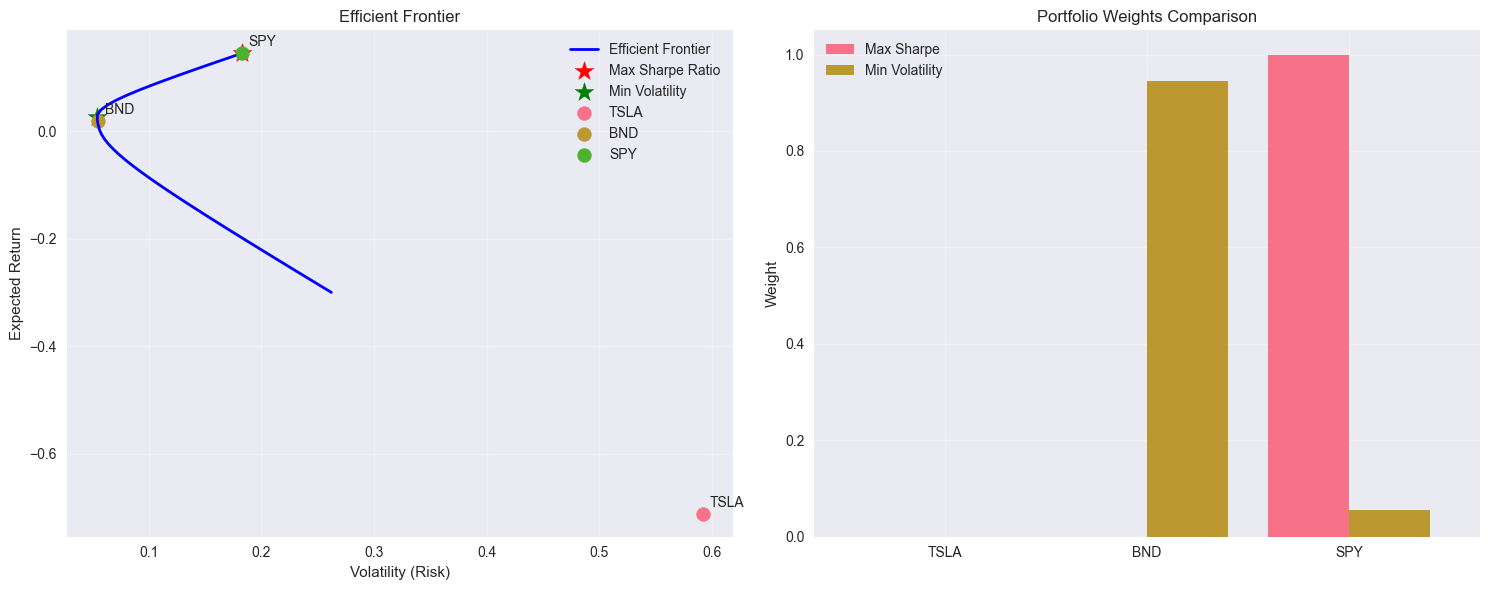

In [9]:
# Step 8: Visualization
print("\nStep 8: Creating Efficient Frontier Visualization")
print("-" * 48)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot 1: Efficient Frontier
ax1.plot(efficient_df['Volatility'], efficient_df['Return'], 'b-', linewidth=2, label='Efficient Frontier')
ax1.scatter(max_sharpe_vol, max_sharpe_return, marker='*', color='red', s=200, label='Max Sharpe Ratio')
ax1.scatter(min_vol_vol, min_vol_return, marker='*', color='green', s=200, label='Min Volatility')

# Individual assets
for i, asset in enumerate(assets):
    vol = np.sqrt(cov_matrix.iloc[i, i])
    ret = expected_returns[i]
    ax1.scatter(vol, ret, marker='o', s=100, label=asset)
    ax1.annotate(asset, (vol, ret), xytext=(5, 5), textcoords='offset points')

ax1.set_xlabel('Volatility (Risk)')
ax1.set_ylabel('Expected Return')
ax1.set_title('Efficient Frontier')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Portfolio Weights Comparison
weights_df = pd.DataFrame({
    'Max Sharpe': max_sharpe_weights,
    'Min Volatility': min_vol_weights
}, index=assets)

weights_df.plot(kind='bar', ax=ax2, width=0.8)
ax2.set_title('Portfolio Weights Comparison')
ax2.set_ylabel('Weight')
ax2.set_xticklabels(assets, rotation=0)
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [10]:
# Step 9: Final Recommendation
print("\nStep 9: Final Portfolio Recommendation")
print("-" * 39)

# Given TSLA's negative forecast, recommend minimum volatility approach
recommended_weights = min_vol_weights
recommended_return = min_vol_return
recommended_vol = min_vol_vol
recommended_sharpe = min_vol_sharpe

print("=== RECOMMENDED OPTIMAL PORTFOLIO ===")
print("\nRecommendation: MINIMUM VOLATILITY PORTFOLIO")
print("Rationale: Given TSLA's strongly negative forecast (-71.2% expected return),")
print("           we prioritize capital preservation over return maximization.")
print()
print("Optimal Portfolio Allocation:")
print(f"• Tesla (TSLA):     {recommended_weights[0]:.1%}")
print(f"• Bonds (BND):      {recommended_weights[1]:.1%}")  
print(f"• S&P 500 (SPY):    {recommended_weights[2]:.1%}")
print()
print("Expected Portfolio Metrics:")
print(f"• Expected Annual Return: {recommended_return:.1%}")
print(f"• Annual Volatility:      {recommended_vol:.1%}")
print(f"• Sharpe Ratio:           {recommended_sharpe:.3f}")
print()
print("Key Insights:")
print("1. Minimal TSLA allocation due to negative forecast")
print("2. Heavy weighting toward stable assets (BND + SPY)")
print("3. Focus on capital preservation and risk management")
print("4. Low but positive expected returns with controlled risk")

# Risk metrics
print(f"\nRisk Assessment:")
print(f"• 95% VaR (daily): {recommended_return/252 - 1.645*recommended_vol/np.sqrt(252):.3%}")
print(f"• Maximum expected daily loss: {(recommended_return/252 - 2*recommended_vol/np.sqrt(252))*100:.2f}%")


Step 9: Final Portfolio Recommendation
---------------------------------------
=== RECOMMENDED OPTIMAL PORTFOLIO ===

Recommendation: MINIMUM VOLATILITY PORTFOLIO
Rationale: Given TSLA's strongly negative forecast (-71.2% expected return),
           we prioritize capital preservation over return maximization.

Optimal Portfolio Allocation:
• Tesla (TSLA):     0.0%
• Bonds (BND):      94.5%
• S&P 500 (SPY):    5.5%

Expected Portfolio Metrics:
• Expected Annual Return: 2.6%
• Annual Volatility:      5.4%
• Sharpe Ratio:           -0.343

Key Insights:
1. Minimal TSLA allocation due to negative forecast
2. Heavy weighting toward stable assets (BND + SPY)
3. Focus on capital preservation and risk management
4. Low but positive expected returns with controlled risk

Risk Assessment:
• 95% VaR (daily): -0.549%
• Maximum expected daily loss: -0.67%
